In [1]:
using Gmsh, TipiFEM, TipiFEM.Meshes, TipiFEM.PolytopalMesh, TipiFEM.Quadrature
using StaticArrays
using PyPlot

# Load msh

In [33]:
msh = Gmsh.load("/home/tehrengruber/.julia/v0.6/Gmsh/assets/triangle_refined_test.msh", mesh_dim=2, world_dim=2)

INFO: Gmsh: reading 25 nodes
INFO: Gmsh: reading 51 elements


TipiFEM.Mesh at Ptr{Void} @0x00007f9072a0f400
  world dim: 2
  mesh dimension: 2
  cell types: Polytope"3-node triangle", Polytope"4-node quadrangle"
   Codim    Dim     #cells
       0      2         32
       1      1         56
       2      0         25
  topology: 
    → | 0  1  2
    --|--------
    0 | 0  0  0     
    1 | 1  0  0     
    2 | 1  1  1

# Setup Finite Element space

In [34]:
basis = FEBasis{:Lagrangian, 1}()
dofh=TipiFEM.DofHandler(msh, basis) # todo: pretty printer

fulltype(TipiFEM.DofHandler{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, TipiFEM.FEBasis{:Lagrangian,1}, fulltype(TipiFEM.Meshes.Mesh{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, 2, Float64})})(fulltype(TipiFEM.Meshes.Mesh{Union{Polytope"3-node triangle", Polytope"4-node quadrangle"}, 2, Float64})(TipiFEM.Meshes.HomogenousMeshFunction{Polytope"1-node point",StaticArrays.SArray{Tuple{2},Float64,1,2},Base.OneTo{TipiFEM.Meshes.Index{Polytope"1-node point"}},Array{StaticArrays.SArray{Tuple{2},Float64,1,2},1}}(Base.OneTo(TipiFEM.Meshes.Index{Polytope"1-node point"}(0x0000000000000019)), StaticArrays.SArray{Tuple{2},Float64,1,2}[[0.0, 0.0], [1.0, 0.0], [0.0, 1.0], [0.0, 0.5], [0.0, 0.25], [0.0, 0.75], [0.5, 0.5], [0.25, 0.75], [0.75, 0.25], [0.125, 0.875]  …  [0.25, 0.0], [0.25, 0.25], [0.125, 0.125], [0.375, 0.125], [0.5, 0.25], [0.625, 0.125], [0.375, 0.375], [0.125, 0.375], [0.125, 0.625], [0.25, 0.5]]), fulltype(TipiFEM.Meshes.MeshTopology{Union{Polyto

In [35]:
# rename some functions for readability
using TipiFEM: number_of_local_shape_functions, local_shape_functions, grad_local_shape_functions

K=Polytope"3-node triangle"()
b̂ = local_shape_functions(basis, K)
grad_b̂=grad_local_shape_functions(basis, K)

3-element Array{TipiFEM.##61#62{Polytope"3-node triangle",TipiFEM.FEBasis{:Lagrangian,1},_} where _,1}:
 TipiFEM.#61
 TipiFEM.#61
 TipiFEM.#61

In [ ]:
n = number_of_local_shape_functions(basis)
function element_matrix(K)
    el_mat = zeros(MMatrix{n, n, Float64})
    grad_local_shape_functions(basis, K)
end

# Define the problem to be solved

In [36]:
using TipiFEM.PolytopalMesh.jacobian_transposed

DΦ⁻¹ = jacobian_inverse_transposed

f(x) = x[1]*x[2]
f(x) = sin(x[1]*x[2])
#f(x) = (8π^2+1)cos(2π.*x[1]).*cos(2π.*x[2])

#a_l(i, j) = K -> integrate_local(x̂->dot(grad_b̂[i](x̂), grad_b̂[j](x̂)), K)
a_l(i, j) = K -> (integrate_local(K) do x̂
    # calculate transformed gradients
    grad_bi = DΦ⁻¹(K, x̂)*grad_b̂[i](x̂)
    grad_bj = DΦ⁻¹(K, x̂)*grad_b̂[j](x̂)
    # evaluate bilinear form
    #  todo: add material function
    dot(grad_bi, grad_bj)
end[1])
a_m(i, j) = K ->  integrate_local(K) do x̂
    dot(b̂[i](x̂), b̂[j](x̂))
end
l(i) = (K -> integrate_local(x->f(local_to_global(K, x))*b̂[i](x), K))

l (generic function with 1 method)

In [37]:
eval(TipiFEM, quote
 include("/home/tehrengruber/.julia/v0.6/TipiFEM/src/fe/fe.jl")
        end)

LoadError: LoadError: LoadError: [91minvalid redefinition of constant DofHandler[39m
while loading /home/tehrengruber/.julia/v0.6/TipiFEM/src/fe/dofhandler.jl, in expression starting on line 521
while loading /home/tehrengruber/.julia/v0.6/TipiFEM/src/fe/fe.jl, in expression starting on line 2

# Test calls

In [38]:
ref_tria = reference_element(Polytope"3-node triangle"())

3×2 fulltype(TipiFEM.Meshes.Geometry{Polytope"3-node triangle", 2, Float64}):
 0.0  0.0
 1.0  0.0
 0.0  1.0

In [39]:
el_lapl_matrix = TipiFEM.element_stiffness_matrix(a_l, Polytope"3-node triangle"(), basis)
map(Aij -> Aij(ref_tria), el_lapl_matrix)

3×3 StaticArrays.SArray{Tuple{3,3},Any,2,9}:
  1.0  -0.5  -0.5
 -0.5   0.5   0.0
 -0.5   0.0   0.5

In [40]:
el_mass_matrix = TipiFEM.element_stiffness_matrix(a_m, Polytope"3-node triangle"(), basis)
map(Aij -> Aij(ref_tria), el_mass_matrix)

3×3 StaticArrays.SArray{Tuple{3,3},Any,2,9}:
 0.0833333  0.0416667  0.0416667
 0.0416667  0.0833333  0.0416667
 0.0416667  0.0416667  0.0833333

In [41]:
el_vec = TipiFEM.element_load_vector(l, Polytope"3-node triangle"(), basis)
map(Vi -> Vi(ref_tria), el_vec)

3-element StaticArrays.SArray{Tuple{3},Any,1,3}:
 0.00831675
 0.0166007 
 0.0166007 

In [42]:
dofh[Index"3-node triangle"(2)]

3-element StaticArrays.MArray{Tuple{3},Int64,1,3}:
 18
 19
 16

In [43]:
using TipiFEM.LagrangianFESpace

In [44]:
geometry(msh)

32 element HeterogenousMeshFunction Union{Polytope"3-node triangle", Polytope"4-node quadrangle"} → Any
├─ 32 element HomogenousMeshFunction Polytope"3-node triangle" → fulltype(TipiFEM.Meshes.Geometry{Polytope"3-node triangle", 2, Float64})
|  (1, [0.0 0.0; 0.125 0.125; 0.25 0.0])
|  (2, [0.125 0.125; 0.375 0.125; 0.25 0.0])
|  (3, [0.125 0.125; 0.25 0.25; 0.375 0.125])
|  (4, [0.25 0.0; 0.375 0.125; 0.5 0.0])
|  (5, [0.25 0.25; 0.5 0.25; 0.375 0.125])
|  (6, [0.5 0.25; 0.625 0.125; 0.375 0.125])
|  (7, [0.5 0.25; 0.75 0.25; 0.625 0.125])
|  (8, [0.375 0.125; 0.625 0.125; 0.5 0.0])
|  (9, [0.25 0.25; 0.375 0.375; 0.5 0.25])
|  (10, [0.375 0.375; 0.625 0.375; 0.5 0.25])
...
├─ 0 element HomogenousMeshFunction Polytope"4-node quadrangle" → Any


# Solve the problem

## Assemble galerkin matrix

In [45]:
m1=TipiFEM.matrix_assembler(a_l, msh, basis, dofh)
m2=TipiFEM.matrix_assembler(a_m, msh, basis, dofh)
#m1[1:10, 1:10]
m=m1+m2
#m[1:10, 1:10]

25×25 SparseMatrixCSC{Float64,Int64} with 137 stored entries:
  [1 ,  1]  =  1.00521
  [5 ,  1]  =  0.00130208
  [16,  1]  =  0.00130208
  [18,  1]  =  -0.997396
  [2 ,  2]  =  0.502604
  [13,  2]  =  -0.498698
  [15,  2]  =  0.00130208
  [3 ,  3]  =  0.502604
  [6 ,  3]  =  0.00130208
  [10,  3]  =  -0.498698
  ⋮
  [10, 24]  =  0.00260417
  [23, 24]  =  0.00260417
  [24, 24]  =  4.01563
  [25, 24]  =  -0.997396
  [8 , 25]  =  0.00260417
  [11, 25]  =  -0.997396
  [17, 25]  =  0.00260417
  [22, 25]  =  -0.997396
  [23, 25]  =  -0.997396
  [24, 25]  =  -0.997396
  [25, 25]  =  4.01563

In [46]:
# display non zero elements in the galerkin matrix
#spy(m)

In [47]:
# Assemble right hand side
v=TipiFEM.vector_assembler(l, msh, basis, dofh)

25-element Array{Float64,1}:
 1.62759e-5 
 0.000146424
 0.000146424
 9.76372e-5 
 5.69622e-5 
 0.000138293
 0.00113    
 0.000954696
 0.000729835
 0.000633081
 0.00111414 
 0.00101058 
 0.000284603
 9.76372e-5 
 0.000138293
 5.69622e-5 
 0.0005037  
 0.000178993
 0.000227777
 0.000866526
 0.000584581
 0.000986566
 0.000365875
 0.000584581
 0.000866526

In [48]:
#m[1, :]=0
#m[1, 1]=1
#v[1]=1

In [49]:
#collect(m)

In [50]:
μ = m\v

25-element Array{Float64,1}:
 0.0226583
 0.0238019
 0.0246894
 0.0237326
 0.0230446
 0.0243178
 0.0248964
 0.0247864
 0.0241284
 0.0246527
 0.0249026
 0.0245606
 0.0237565
 0.0233909
 0.0236345
 0.0229415
 0.0234139
 0.0228795
 0.0233059
 0.0239794
 0.0237441
 0.0241883
 0.023514 
 0.0242249
 0.024235 

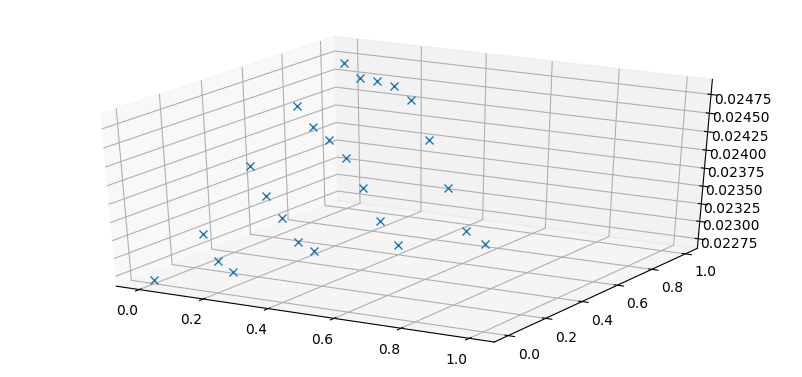

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f903b20fd50>

In [51]:
# todo: missing constant somewhere. values are to low
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d")
ax[:plot](map(x->x[1], image(msh.nodes)), map(x->x[2], image(msh.nodes)), μ, "x")

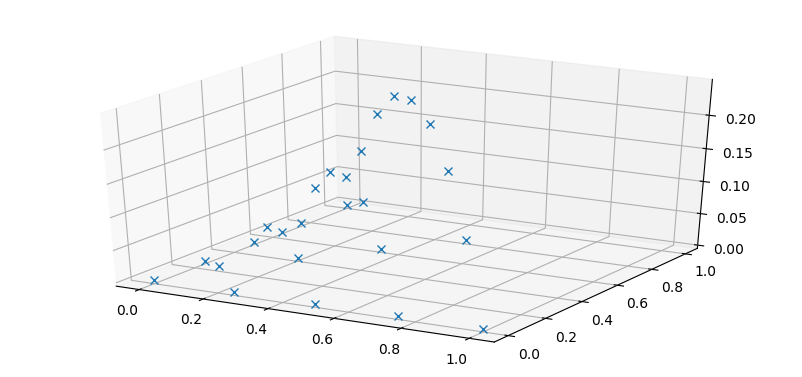

1-element Array{Any,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7f903b0ee490>

In [52]:
#u(x, y) = 1/6*x*x*x+1/6*y*y*y
#u(x, y) = 1+1/2*x*x+1/2*y*y
u(x, y) = sin(x*y)
fig = figure("pyplot_surfaceplot",figsize=(10,10))
ax = fig[:add_subplot](2,1,1, projection = "3d")
ax[:plot](map(x->x[1], image(msh.nodes)), map(x->x[2], image(msh.nodes)), image(map(x->u(x[1], x[2]), msh.nodes)), "x")

In [54]:
map(x->u(x[1], x[2]), msh.nodes)

25 element HomogenousMeshFunction Polytope"1-node point" → Float64
(1, 0.0)
(2, 0.0)
(3, 0.0)
(4, 0.0)
(5, 0.0)
(6, 0.0)
(7, 0.24740395925452294)
(8, 0.18640329676185627)
(9, 0.1864032967626835)
(10, 0.1091570568750085)
...
